In [7]:
import os
from tqdm import *
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import Parameter
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.cluster import KMeans
import numpy as np
from tqdm import *
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import pandas as pd

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28))
        self.model = nn.Sequential(self.encoder, self.decoder)
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
class ClusteringLayer(nn.Module): # inherit nn.Module for computing gradient
    def __init__(self, n_clusters=10, latent_dim=10, cluster_centers=None, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.latent_dim = latent_dim
        if cluster_centers is None:
            initial_cluster_centers = torch.zeros(
            self.n_clusters,
            self.latent_dim,
            dtype=torch.float
            )
            nn.init.xavier_uniform_(initial_cluster_centers)
        else:
            initial_cluster_centers = cluster_centers
        self.cluster_centers = Parameter(initial_cluster_centers)
    def forward(self, x):
        norm_squared = torch.sum((x.unsqueeze(1) - self.cluster_centers)**2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2
        numerator = numerator**power
        t_dist = (numerator.t() / torch.sum(numerator, 1)).t() #soft assignment using t-distribution
        return t_dist

In [9]:
class AE_KMeans(nn.Module):           # inherit nn.Module for computing gradient
    def __init__(self, n_clusters=10, autoencoder=None, latent_dim=10, cluster_centers=None, alpha=1.0):
        super(AE_KMeans, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.latent_dim = latent_dim
        self.cluster_centers = cluster_centers
        self.autoencoder = autoencoder
        self.clusteringlayer = ClusteringLayer(self.n_clusters, self.latent_dim, self.cluster_centers, self.alpha)

    def target_distribution(self, q_):
        weight = (q_ ** 2) / torch.sum(q_, 0)
        return (weight.t() / torch.sum(weight, 1)).t()

    def forward(self, x):
        x = self.autoencoder.encode(x) 
        return self.clusteringlayer(x)

    def visualize(self, epoch,x):
        fig = plt.figure()
        ax = plt.subplot(111)
        x = self.autoencoder.encode(x).detach() 
        x = x.numpy()[:2000]                      # fixing
        x_embedded = TSNE(n_components=2).fit_transform(x)
        plt.scatter(x_embedded[:,0], x_embedded[:,1])
        # dirWriteName = os.path.join(".", "output")
        # os.makedirs(os.path.dirname(dirWriteName), exist_ok=True) # create 'output' folder if not existed yet
        fig.savefig('mnist_{}.png'.format(epoch))
        plt.close(fig)

In [10]:
def train_AE_initial(**kwargs):
    data = kwargs['data']
    model = kwargs['model']
    num_epochs = kwargs['num_epochs']
    start_epoch = 0
    parameters = list(autoencoder.parameters())
    optimizer = torch.optim.Adam(parameters, lr=1e-3, weight_decay=1e-5)
    train_loader = DataLoader(dataset=data,
                    batch_size=128, 
                    shuffle=True)
    for epoch in range(start_epoch, num_epochs):
        for data in train_loader:
            img  = data.float()
            # ===================forward=====================
            output = model(img)
            output = output.squeeze(1)
            output = output.view(output.size(0), 28*28)
            loss = nn.MSELoss()(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], MSE_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

In [11]:
def train(**kwargs):
    data = kwargs['data']
    labels = kwargs['labels']
    model = kwargs['model']
    num_epochs = kwargs['num_epochs']

    latent_features = []
    train_loader = DataLoader(dataset=data,
                              batch_size=128, 
                              shuffle=False)

    # ----------------------- train AE -----------------------
    # pretrain(data=x, model=autoencoder, num_epochs=epochs_pre, savepath=ae_save_path, checkpoint=checkpoint)

    for i, batch in enumerate(train_loader):
        img = batch.float()
        latent_features.append(model.autoencoder.encode(img).detach())   # fixing
    latent_features = torch.cat(latent_features)
    # ------------------------- K-means to init cluster centers ------------------------- 
    kmeans = KMeans(n_clusters=10, random_state=0).fit(latent_features)
    cluster_centers = kmeans.cluster_centers_
    cluster_centers = torch.tensor(cluster_centers, dtype=torch.float)
    model.clusteringlayer.cluster_centers = torch.nn.Parameter(cluster_centers)
    # ------------------------- minimize loss w.r.t. clustter centers & weights of AE encoder -------------------------
    y_pred = kmeans.predict(latent_features)
    accuracy = acc(y.numpy(), y_pred)
    print('Initial Accuracy: {}'.format(accuracy))

    loss_function = nn.KLDivLoss(size_average=False)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
    
    print('Training')
    row = []
    for epoch in range(0, num_epochs):
        batch = data
        img = batch.float()
        output = model(img)
        target = model.target_distribution(output).detach()
        out = output.argmax(1)
        if epoch % 20 == 0:
            print('plotting')
            ae_kmeans.visualize(epoch, img)
        loss = loss_function(output.log(), target) / output.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = acc(y.numpy(), out.numpy())
        row.append([epoch, accuracy, loss])

        print('Epochs: [{}/{}] Accuracy:{}, Loss:{}'.format(epoch, num_epochs, accuracy, loss))
    visualize(row)
    df = pd.DataFrame(row, columns=['epochs', 'accuracy'])
    df.to_csv('log.csv')

In [12]:
def visualize(row):
      %matplotlib inline
      import matplotlib.pyplot as plt
      import numpy as np

      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
      fig.suptitle('Plotting results')
      epoch = np.asarray(row)[:,0]
      ACC = np.asarray(row)[:,1]
      ax1.plot(epoch, ACC)
      ax1.set_title('ACC w.r.t. epochs')

      epoch = np.asarray(row)[:,0]
      loss = np.asarray(row)[:,2]
      ax2.plot(epoch, loss)
      ax2.set_title('Loss w.r.t. epochs')

In [13]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [14]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    train = MNIST(root='./data/',
                train=True, 
                transform=transforms.ToTensor(),
                download=True)

    test = MNIST(root='./data/',
                train=False, 
                transform=transforms.ToTensor())
    x_train, y_train = train.train_data, train.train_labels
    x_test, y_test = test.test_data, test.test_labels
    x = torch.cat((x_train, x_test), 0)
    y = torch.cat((y_train, y_test), 0)
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y
load_mnist()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


MNIST samples torch.Size([70000, 784])


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([5, 0, 4,  ..., 4, 5, 6]))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


MNIST samples torch.Size([70000, 784])
epoch [1/20], MSE_loss:0.0442
epoch [2/20], MSE_loss:0.0371
epoch [3/20], MSE_loss:0.0314
epoch [4/20], MSE_loss:0.0302
epoch [5/20], MSE_loss:0.0306
epoch [6/20], MSE_loss:0.0334
epoch [7/20], MSE_loss:0.0297
epoch [8/20], MSE_loss:0.0273
epoch [9/20], MSE_loss:0.0258
epoch [10/20], MSE_loss:0.0262
epoch [11/20], MSE_loss:0.0229
epoch [12/20], MSE_loss:0.0241
epoch [13/20], MSE_loss:0.0251
epoch [14/20], MSE_loss:0.0250
epoch [15/20], MSE_loss:0.0270
epoch [16/20], MSE_loss:0.0241
epoch [17/20], MSE_loss:0.0230
epoch [18/20], MSE_loss:0.0276
epoch [19/20], MSE_loss:0.0246
epoch [20/20], MSE_loss:0.0242


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Initial Accuracy: 0.6631285714285714
Training
plotting


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [0/200] Accuracy:0.6631285714285714, Loss:0.23937483131885529
Epochs: [1/200] Accuracy:0.6635428571428571, Loss:0.2401958405971527
Epochs: [2/200] Accuracy:0.6635, Loss:0.24116072058677673
Epochs: [3/200] Accuracy:0.6684428571428571, Loss:0.24685031175613403
Epochs: [4/200] Accuracy:0.6699857142857143, Loss:0.25153952836990356
Epochs: [5/200] Accuracy:0.6666, Loss:0.25370946526527405
Epochs: [6/200] Accuracy:0.6642285714285714, Loss:0.25410059094429016
Epochs: [7/200] Accuracy:0.6670714285714285, Loss:0.2550358474254608
Epochs: [8/200] Accuracy:0.6662142857142858, Loss:0.25486519932746887
Epochs: [9/200] Accuracy:0.6610857142857143, Loss:0.2534482181072235
Epochs: [10/200] Accuracy:0.6607428571428572, Loss:0.2517818510532379
Epochs: [11/200] Accuracy:0.6645285714285715, Loss:0.2511642873287201
Epochs: [12/200] Accuracy:0.6632571428571429, Loss:0.24920125305652618
Epochs: [13/200] Accuracy:0.6605857142857143, Loss:0.24637649953365326
Epochs: [14/200] Accuracy:0.6634428571428571,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [20/200] Accuracy:0.664, Loss:0.2336938977241516
Epochs: [21/200] Accuracy:0.6644714285714286, Loss:0.2312878668308258
Epochs: [22/200] Accuracy:0.6647285714285714, Loss:0.22821196913719177
Epochs: [23/200] Accuracy:0.6671428571428571, Loss:0.22737589478492737
Epochs: [24/200] Accuracy:0.6670285714285714, Loss:0.22419029474258423
Epochs: [25/200] Accuracy:0.6697142857142857, Loss:0.22138236463069916
Epochs: [26/200] Accuracy:0.6718857142857143, Loss:0.21905048191547394
Epochs: [27/200] Accuracy:0.6717142857142857, Loss:0.2161504030227661
Epochs: [28/200] Accuracy:0.6739714285714286, Loss:0.21551604568958282
Epochs: [29/200] Accuracy:0.6747428571428571, Loss:0.21223658323287964
Epochs: [30/200] Accuracy:0.6769142857142857, Loss:0.21145689487457275
Epochs: [31/200] Accuracy:0.6765857142857142, Loss:0.20859484374523163
Epochs: [32/200] Accuracy:0.6789285714285714, Loss:0.20761635899543762
Epochs: [33/200] Accuracy:0.6790571428571428, Loss:0.20393326878547668
Epochs: [34/200] Accur

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [40/200] Accuracy:0.6880428571428572, Loss:0.21070638298988342
Epochs: [41/200] Accuracy:0.6862, Loss:0.19219546020030975
Epochs: [42/200] Accuracy:0.6820857142857143, Loss:0.19433456659317017
Epochs: [43/200] Accuracy:0.6890857142857143, Loss:0.22300563752651215
Epochs: [44/200] Accuracy:0.6753142857142858, Loss:0.21196289360523224
Epochs: [45/200] Accuracy:0.6910857142857143, Loss:0.19740845263004303
Epochs: [46/200] Accuracy:0.6904, Loss:0.1843082457780838
Epochs: [47/200] Accuracy:0.6868142857142857, Loss:0.18988816440105438
Epochs: [48/200] Accuracy:0.6929142857142857, Loss:0.20564395189285278
Epochs: [49/200] Accuracy:0.6904285714285714, Loss:0.1868254691362381
Epochs: [50/200] Accuracy:0.6952, Loss:0.17911182343959808
Epochs: [51/200] Accuracy:0.6964285714285714, Loss:0.18348905444145203
Epochs: [52/200] Accuracy:0.6939857142857143, Loss:0.18586604297161102
Epochs: [53/200] Accuracy:0.6985, Loss:0.19005703926086426
Epochs: [54/200] Accuracy:0.6976714285714286, Loss:0.175

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [60/200] Accuracy:0.7026857142857142, Loss:0.16738250851631165
Epochs: [61/200] Accuracy:0.7024714285714285, Loss:0.16872790455818176
Epochs: [62/200] Accuracy:0.7035857142857143, Loss:0.16913986206054688
Epochs: [63/200] Accuracy:0.7023857142857143, Loss:0.1740553230047226
Epochs: [64/200] Accuracy:0.7039714285714286, Loss:0.1690898984670639
Epochs: [65/200] Accuracy:0.7027857142857142, Loss:0.16841071844100952
Epochs: [66/200] Accuracy:0.7047428571428571, Loss:0.16272468864917755
Epochs: [67/200] Accuracy:0.7044857142857143, Loss:0.16125136613845825
Epochs: [68/200] Accuracy:0.7049285714285715, Loss:0.1603923738002777
Epochs: [69/200] Accuracy:0.7055428571428571, Loss:0.15993322432041168
Epochs: [70/200] Accuracy:0.7046, Loss:0.1624298095703125
Epochs: [71/200] Accuracy:0.7061571428571428, Loss:0.16139774024486542
Epochs: [72/200] Accuracy:0.7044428571428571, Loss:0.16425812244415283
Epochs: [73/200] Accuracy:0.7064142857142857, Loss:0.1614314466714859
Epochs: [74/200] Accura

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [80/200] Accuracy:0.7069571428571428, Loss:0.1525091975927353
Epochs: [81/200] Accuracy:0.7069714285714286, Loss:0.15186552703380585
Epochs: [82/200] Accuracy:0.7071142857142857, Loss:0.15126977860927582
Epochs: [83/200] Accuracy:0.707, Loss:0.15137270092964172
Epochs: [84/200] Accuracy:0.7076571428571429, Loss:0.15063051879405975
Epochs: [85/200] Accuracy:0.7071285714285714, Loss:0.15145644545555115
Epochs: [86/200] Accuracy:0.7080285714285715, Loss:0.15075914561748505
Epochs: [87/200] Accuracy:0.7072142857142857, Loss:0.15276314318180084
Epochs: [88/200] Accuracy:0.7085857142857143, Loss:0.1523161083459854
Epochs: [89/200] Accuracy:0.7071142857142857, Loss:0.1559508591890335
Epochs: [90/200] Accuracy:0.7091285714285714, Loss:0.1551310271024704
Epochs: [91/200] Accuracy:0.7071714285714286, Loss:0.15873220562934875
Epochs: [92/200] Accuracy:0.7093285714285714, Loss:0.1551005095243454
Epochs: [93/200] Accuracy:0.7076714285714286, Loss:0.15514884889125824
Epochs: [94/200] Accurac

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [100/200] Accuracy:0.7087142857142857, Loss:0.1470400094985962
Epochs: [101/200] Accuracy:0.7097714285714286, Loss:0.14593271911144257
Epochs: [102/200] Accuracy:0.7085714285714285, Loss:0.1467142105102539
Epochs: [103/200] Accuracy:0.7099, Loss:0.14438077807426453
Epochs: [104/200] Accuracy:0.7092, Loss:0.14403490722179413
Epochs: [105/200] Accuracy:0.7099285714285715, Loss:0.14217106997966766
Epochs: [106/200] Accuracy:0.7095714285714285, Loss:0.14173968136310577
Epochs: [107/200] Accuracy:0.7097, Loss:0.14109723269939423
Epochs: [108/200] Accuracy:0.7098142857142857, Loss:0.1407642811536789
Epochs: [109/200] Accuracy:0.7097857142857142, Loss:0.14106588065624237
Epochs: [110/200] Accuracy:0.7103, Loss:0.14064061641693115
Epochs: [111/200] Accuracy:0.7096857142857143, Loss:0.14146490395069122
Epochs: [112/200] Accuracy:0.7105857142857143, Loss:0.14079776406288147
Epochs: [113/200] Accuracy:0.7096714285714286, Loss:0.14184248447418213
Epochs: [114/200] Accuracy:0.71087142857142

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [120/200] Accuracy:0.7110714285714286, Loss:0.1383563131093979
Epochs: [121/200] Accuracy:0.7104142857142857, Loss:0.1383410096168518
Epochs: [122/200] Accuracy:0.7111, Loss:0.13705529272556305
Epochs: [123/200] Accuracy:0.7106, Loss:0.13690702617168427
Epochs: [124/200] Accuracy:0.7110857142857143, Loss:0.136055588722229
Epochs: [125/200] Accuracy:0.7108285714285715, Loss:0.13585975766181946
Epochs: [126/200] Accuracy:0.7110142857142857, Loss:0.1354065090417862
Epochs: [127/200] Accuracy:0.7110571428571428, Loss:0.13516299426555634
Epochs: [128/200] Accuracy:0.7112285714285714, Loss:0.1349993199110031
Epochs: [129/200] Accuracy:0.7113142857142857, Loss:0.13468173146247864
Epochs: [130/200] Accuracy:0.7112, Loss:0.13472329080104828
Epochs: [131/200] Accuracy:0.7116571428571429, Loss:0.13432660698890686
Epochs: [132/200] Accuracy:0.7112571428571428, Loss:0.13455648720264435
Epochs: [133/200] Accuracy:0.7119571428571428, Loss:0.13410057127475739
Epochs: [134/200] Accuracy:0.71155

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [140/200] Accuracy:0.7115571428571429, Loss:0.13647784292697906
Epochs: [141/200] Accuracy:0.7127857142857142, Loss:0.1354825645685196
Epochs: [142/200] Accuracy:0.7116571428571429, Loss:0.13661126792430878
Epochs: [143/200] Accuracy:0.7128285714285715, Loss:0.13484784960746765
Epochs: [144/200] Accuracy:0.7118857142857142, Loss:0.13501271605491638
Epochs: [145/200] Accuracy:0.7129714285714286, Loss:0.13289327919483185
Epochs: [146/200] Accuracy:0.7121571428571428, Loss:0.13242207467556
Epochs: [147/200] Accuracy:0.7130857142857143, Loss:0.13092055916786194
Epochs: [148/200] Accuracy:0.7125571428571429, Loss:0.13052137196063995
Epochs: [149/200] Accuracy:0.7128571428571429, Loss:0.13006603717803955
Epochs: [150/200] Accuracy:0.7130857142857143, Loss:0.12989269196987152
Epochs: [151/200] Accuracy:0.7127428571428571, Loss:0.13022109866142273
Epochs: [152/200] Accuracy:0.7131428571428572, Loss:0.13000929355621338
Epochs: [153/200] Accuracy:0.7127428571428571, Loss:0.13063748180866

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [160/200] Accuracy:0.7136714285714286, Loss:0.12852400541305542
Epochs: [161/200] Accuracy:0.7130571428571428, Loss:0.12851054966449738
Epochs: [162/200] Accuracy:0.7136285714285714, Loss:0.1277747005224228
Epochs: [163/200] Accuracy:0.7132857142857143, Loss:0.1276887208223343
Epochs: [164/200] Accuracy:0.7135714285714285, Loss:0.12717454135417938
Epochs: [165/200] Accuracy:0.7133571428571429, Loss:0.12704667448997498
Epochs: [166/200] Accuracy:0.7135142857142858, Loss:0.12673556804656982
Epochs: [167/200] Accuracy:0.7134142857142857, Loss:0.12656821310520172
Epochs: [168/200] Accuracy:0.7134428571428572, Loss:0.12641285359859467
Epochs: [169/200] Accuracy:0.7136285714285714, Loss:0.12619994580745697
Epochs: [170/200] Accuracy:0.7135714285714285, Loss:0.12615562975406647
Epochs: [171/200] Accuracy:0.7136, Loss:0.12589424848556519
Epochs: [172/200] Accuracy:0.7135571428571429, Loss:0.1259324699640274
Epochs: [173/200] Accuracy:0.7137857142857142, Loss:0.12562614679336548
Epochs:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Epochs: [180/200] Accuracy:0.7137428571428571, Loss:0.1256561577320099
Epochs: [181/200] Accuracy:0.7141285714285714, Loss:0.12524542212486267
Epochs: [182/200] Accuracy:0.7137285714285714, Loss:0.12594032287597656
Epochs: [183/200] Accuracy:0.7142714285714286, Loss:0.12547221779823303
Epochs: [184/200] Accuracy:0.7137285714285714, Loss:0.1263233721256256
Epochs: [185/200] Accuracy:0.7142714285714286, Loss:0.1256919503211975
Epochs: [186/200] Accuracy:0.7136857142857143, Loss:0.12650083005428314
Epochs: [187/200] Accuracy:0.7143857142857143, Loss:0.12556450068950653
Epochs: [188/200] Accuracy:0.7137857142857142, Loss:0.12604136765003204
Epochs: [189/200] Accuracy:0.7143571428571428, Loss:0.12480984628200531
Epochs: [190/200] Accuracy:0.7140571428571428, Loss:0.12484681606292725
Epochs: [191/200] Accuracy:0.7143, Loss:0.12361061573028564
Epochs: [192/200] Accuracy:0.7143, Loss:0.12340103089809418
Epochs: [193/200] Accuracy:0.7143428571428572, Loss:0.12251226603984833
Epochs: [194/200] A

ValueError: ignored

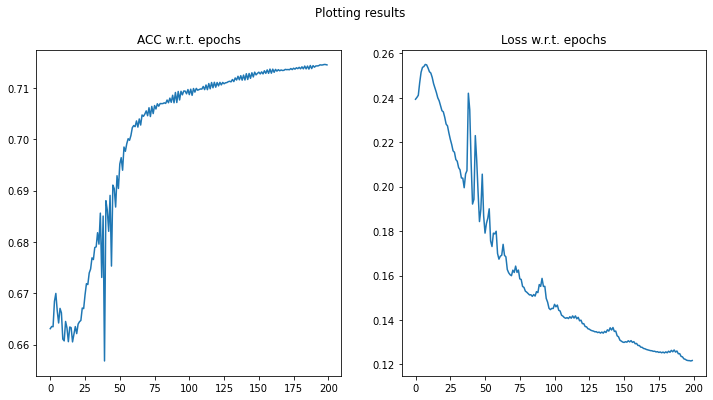

In [15]:
if __name__ == '__main__':
    batch_size=256
    epochs_inital=20
    epochs=200
    x, y = load_mnist()
    autoencoder = AutoEncoder()	
    train_AE_initial(data=x, model=autoencoder, num_epochs=epochs_inital)
    
    ae_kmeans = AE_KMeans(n_clusters=10, autoencoder=autoencoder, latent_dim=10, cluster_centers=None, alpha=1.0)
    train(data=x, labels=y, model=ae_kmeans, num_epochs=epochs)

In [ ]:
# ------------------ THE ERRORS ABOVE PLOTTING CAN BE IGNORED ------------------ 